In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from math import sqrt

import os
import warnings
warnings.filterwarnings('ignore')


## **Exploratory Data Analysis (EDA)**

In [3]:
all_data_df = pd.read_csv('Data.csv')

In [4]:
# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])
all_data_df = all_data_df.sort_values(by='date_time').reset_index(drop=True)


In [5]:
all_data_df.tail(3)

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
39147556,2024-09-23 23:55:00,NaN,0.00,0.00,0.000000,consumer_device_16_data_user_9,NaN,0.00,0,16
39147557,2024-09-23 23:55:00,NaN,0.05,0.72,0.000565,consumer_device_26_data_user_14,NaN,188.37,0,26
39147558,2024-09-23 23:55:00,NaN,0.06,0.74,0.000695,consumer_device_12_data_user_2,187.86,NaN,0,12


In [6]:
all_data_df.isnull().sum()

date_time                   0
v_red                25328292
current                     0
power_factor                0
kwh                         0
Source                      0
v_blue               26899165
v_yellow             26067661
consumer_device_9           0
consumer_device_x           0
dtype: int64

In [7]:
# Count how many phase columns are non-null per row
all_data_df['active_phases'] = all_data_df[['v_red', 'v_blue', 'v_yellow']].notnull().sum(axis=1)

# Check distribution of active phases
phase_counts = all_data_df['active_phases'].value_counts().sort_index()
print("Number of active phases per row:")
print(phase_counts)

# Count rows where none of the phases are active
num_inactive = (all_data_df['active_phases'] == 0).sum()
print(f"\nNumber of rows with no active phases (all NaN): {num_inactive}")

# Check if single-phase data
if phase_counts.index.max() == 1:
    print("\nConfirmed: Each row has exactly one active phase (single-phase recording).")
else:
    print("\nSome rows have more than one phase active at the same time.")

# Check rows with more than 1 active phase
multi_phase_rows = all_data_df[all_data_df['active_phases'] > 1]
if not multi_phase_rows.empty:
    print("\nRows with multiple active phases detected:")
    print(multi_phase_rows[['date_time','v_red','v_blue','v_yellow']].head(10))

# Check rows with zero active phases
inactive_rows = all_data_df[all_data_df['active_phases'] == 0]
if not inactive_rows.empty:
    print("\nRows with no active phases (all NaN):")
    print(inactive_rows[['date_time','v_red','v_blue','v_yellow']].head(10))


Number of active phases per row:
active_phases
1    39147559
Name: count, dtype: int64

Number of rows with no active phases (all NaN): 0

Confirmed: Each row has exactly one active phase (single-phase recording).


In [8]:
all_data_df = all_data_df.copy()

# Datetime to sort
all_data_df = all_data_df.sort_values('date_time').reset_index(drop=True)

# Time in hours
all_data_df['time_delta_hours'] = all_data_df['date_time'].diff().dt.total_seconds() / 3600

# Safely set the first row
all_data_df.loc[0, 'time_delta_hours'] = 5 / 60  # 0.08333 hours

# Extreme deltas
all_data_df['time_delta_hours'] = all_data_df['time_delta_hours'].clip(lower=0.001, upper=0.2)

# Estimated kWh for each interval
all_data_df['kwh_estimated'] = (all_data_df['active_phases'] * all_data_df['current'] * all_data_df['power_factor'] * all_data_df['time_delta_hours']) / 1000

# Residuals
all_data_df['residual'] = all_data_df['kwh'] - all_data_df['kwh_estimated']

# Check matches
tolerance = 0.01
all_data_df['match'] = np.isclose(all_data_df['kwh'], all_data_df['kwh_estimated'], atol=tolerance)

num_correct = all_data_df['match'].sum()
num_incorrect = (~all_data_df['match']).sum()

print(f"Number of rows where formula is correct: {num_correct}")
print(f"Number of rows where formula is incorrect: {num_incorrect}")


Number of rows where formula is correct: 38131212
Number of rows where formula is incorrect: 1016347


In [9]:
#  Load the climate data

file_path = "Kalam Climate Data.xlsx"   
climate_df = pd.read_excel(file_path)

In [10]:
# Ensure datetime
climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

In [11]:
climate_df.tail(2)

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
12226,2024-10-24 23:00:00,-6.864859,-8.32897,-0.058334,-1.272537,0.000399,0.000130,7.871094
12227,2024-10-25 00:00:00,-7.224661,-8.73522,-0.076797,-1.251801,0.000399,0.000131,7.875000


In [12]:
climate_df.isnull().sum().sum()

0

In [13]:
climate_df.isna().sum().sum()

0

### Merging climate and power datasets. Moving from hourly to Daily forecasting.

In [ ]:
#  Load the climate data

file_path = "Kalam Climate Data.xlsx"   
climate_df = pd.read_excel(file_path)

climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

# Extract date

climate_df['date'] = climate_df['Date Time'].dt.date

# Daily aggregation
daily_climate = climate_df.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

daily_climate["date"] = pd.to_datetime(daily_climate["date"])

# Filter DataFrame
extra_month_df = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]


new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}


extra_month_df.rename(columns=new_names, inplace=True)

all_data_df = pd.read_csv("Data.csv")

all_data_df.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow", "current", "power_factor"], inplace=True)
all_data_df.head()

# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])


# Extract date (drop time)
all_data_df['date'] = all_data_df['date_time'].dt.date


# Group by Source (consumer_device + data_user) and date

daily_df = all_data_df.groupby(['Source', 'date']).agg({
    'kwh': 'sum'  
})

daily_df = daily_df.reset_index()


# Ensure datetime index
daily_df = daily_df.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily_df = daily_df.join(daily_climate, how="left")


merged_daily_df.reset_index(inplace=True)

merged_daily_df.to_csv("second_daily_merged_hydro_climate.csv", index=False)


# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily_df.rename(columns=new_names, inplace=True)

In [15]:
merged_daily_df.tail(2)

,Date,Source,kwh,Temp_Mean,Temp_Min,Temp_Max,Dewpoint_Mean,Dewpoint_Min,Dewpoint_Max,U_Wind_Mean,V_Wind_Mean,Precipitation_Sum,Snowfall_Sum,SnowCover_Mean
136407,2024-09-23,consumer_device_36_data_user_16,0.261421,13.384137,4.670419,21.034174,3.404842,-2.298209,9.051385,0.050238,-0.223926,0.000249,0.0,0.0
136408,2024-09-23,consumer_device_22_data_user_12,0.062540,13.384137,4.670419,21.034174,3.404842,-2.298209,9.051385,0.050238,-0.223926,0.000249,0.0,0.0


In [16]:
# Check min/max date
print("Dataset covers:", merged_daily_df.index.min(), "to", merged_daily_df.index.max())

# Create full expected daily date range
full_range = pd.date_range(start="2023-06-03", end="2024-09-23", freq="D")

# Compare with your actual dataset index
missing_dates = full_range.difference(merged_daily_df.index)

print("Number of missing days:", len(missing_dates))
print("Missing days:", missing_dates[:20])  # show first 20 if many

Dataset covers: 0 to 136408
Number of missing days: 479
Missing days: DatetimeIndex(['2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-10',
               '2023-06-11', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16', '2023-06-17', '2023-06-18',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22'],
              dtype='datetime64[ns]', freq='D')


In [17]:
# Loop through all consumers
sources = merged_daily_df['Source'].unique()
for source in sources:
    df_source = merged_daily_df[merged_daily_df['Source'] == source].copy()
    df_source = df_source.sort_index()
    
    # Create complete daily index
    full_idx = pd.date_range(df_source.index.min(), df_source.index.max(), freq='D')
    df_source = df_source.reindex(full_idx)
    
    # Count missing days
    missing_days = df_source['kwh'].isna().sum()
    if missing_days > 0:
        print(f"Consumer {source} has {missing_days} missing days.")
    else:
        print(f"Consumer {source} has no missing days.")


Consumer consumer_device_3_data_user_9 has 1 missing days.
Consumer consumer_device_3_data_user_4 has 1 missing days.
Consumer consumer_device_3_data_user_3 has 1 missing days.
Consumer consumer_device_3_data_user_11 has 1 missing days.
Consumer consumer_device_3_data_user_5 has 1 missing days.
Consumer consumer_device_3_data_user_7 has 1 missing days.
Consumer consumer_device_3_data_user_1 has 1 missing days.
Consumer consumer_device_3_data_user_10 has 1 missing days.
Consumer consumer_device_3_data_user_6 has 1 missing days.
Consumer consumer_device_3_data_user_2 has 1 missing days.
Consumer consumer_device_3_data_user_8 has 1 missing days.
Consumer consumer_device_16_data_user_9 has 1 missing days.
Consumer consumer_device_16_data_user_18 has 1 missing days.
Consumer consumer_device_16_data_user_7 has 1 missing days.
Consumer consumer_device_16_data_user_1 has 1 missing days.
Consumer consumer_device_16_data_user_8 has 1 missing days.
Consumer consumer_device_16_data_user_3 has 1 mi

## **Prophet Model Testing**.

**First Prophet Model.**

In [18]:
df = merged_daily_df.copy()
df = df.sort_values('Date')

target = 'kwh'
climate_features = [
       'Temp_Mean', 'Temp_Min',
       'Temp_Max', 'Dewpoint_Mean',
       'Dewpoint_Min', 'Dewpoint_Max',
       'U_Wind_Mean', 'V_Wind_Mean',
       'Precipitation_Sum', 'Snowfall_Sum',
       'SnowCover_Mean'
]

# Lag and rolling features
df['kwh_lag1'] = df[target].shift(1)
df['kwh_lag7'] = df[target].shift(7)
df['kwh_roll7'] = df[target].rolling(7).mean()
df = df.dropna()


# Drop NaN only for training/testing
df_train_test = df.dropna().reset_index(drop=True)

# Prophet format
prophet_df = df_train_test.rename(columns={'Date':'ds', target:'y'})

# Train-Test split
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# Prophet model
m = Prophet()

# Add regressors
for col in climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']:
    m.add_regressor(col)

# Fit
m.fit(train[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']])
#save train features
train_features = train[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']]
train_features.to_csv('models/prophet_train_features.csv', index=False)

#save the model
import pickle
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)

# Predict test
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']])
#save test features
test_features = test[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']]
test_features.to_csv('models/prophet_test_features.csv', index=False)

rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")


18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:54 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 8.64


**Prophet Model with higher RMSE.**

In [19]:
df = merged_daily_df.copy()
df = df.sort_values('Date')

target = 'kwh'
climate_features = [
    'Temp_Mean', 'Temp_Min', 'Temp_Max',
    'Dewpoint_Mean', 'Dewpoint_Min', 'Dewpoint_Max',
    'U_Wind_Mean', 'V_Wind_Mean',
    'Precipitation_Sum', 'Snowfall_Sum', 'SnowCover_Mean'
]

# --- Lag features ---
df['kwh_lag1'] = df.groupby('Source')[target].shift(1)
df['kwh_lag7'] = df.groupby('Source')[target].shift(7)
df['kwh_roll7'] = df.groupby('Source')[target].shift(1).rolling(7).mean()
df = df.dropna().reset_index(drop=True)

# --- Prophet format ---
prophet_df = df.rename(columns={'Date':'ds', target:'y'})

# --- Train/Test split ---
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# --- Train Prophet model ---
m = Prophet()
for col in climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']:
    m.add_regressor(col)

m.fit(train[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']])

#save train features
train_features = train[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']]
train_features.to_csv('models/prophet_train_features.csv', index=False)

#save the model
import pickle
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)

# --- Predict on test ---
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']])

#save test features
test_features = test[['ds','y'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']]
test_features.to_csv('models/prophet_test_features.csv', index=False)

rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")

18:25:03 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 4.41


**Prediction for the extra month. Creation of Submission file for Zindi.**

Submission file saved as prophet_submission_all_sources.csv


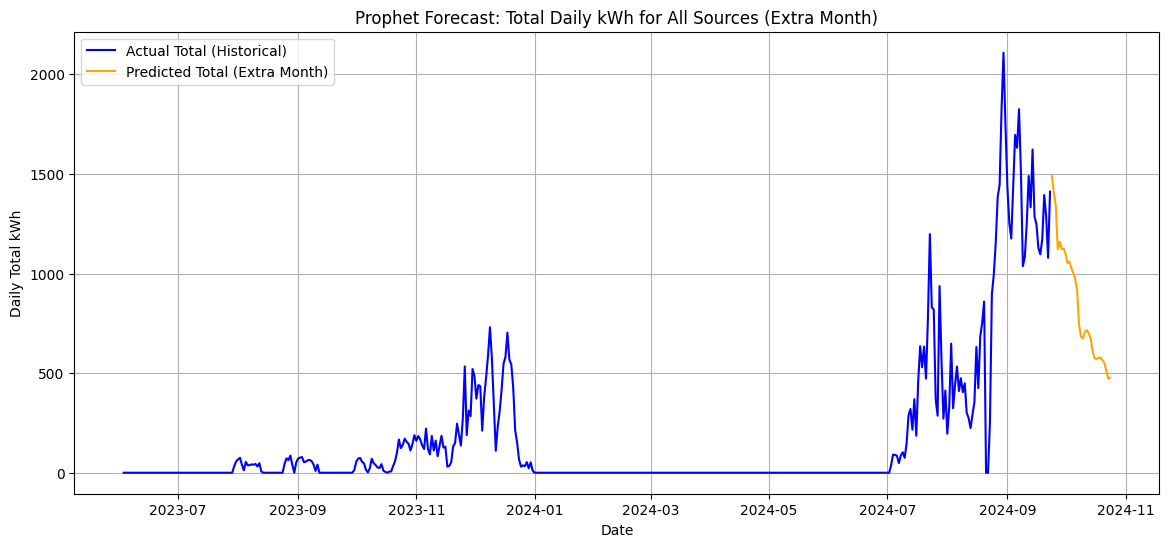

In [20]:
# --- Extra month forecast per source ---
extra_month_df['ds'] = pd.to_datetime(extra_month_df['Date'])
all_sources = merged_daily_df['Source'].unique()
submission_rows = []

# Initialize a DataFrame for daily total predictions
daily_total = pd.DataFrame({'ds': extra_month_df['ds'].unique()})
daily_total['pred_total_kwh'] = 0

for source in all_sources:
    # Historical data per source
    df_source = merged_daily_df[merged_daily_df['Source']==source].sort_values('Date').reset_index(drop=True)
    
    # Lag history (last 30 days)
    lag_hist = df_source.tail(30).copy().reset_index(drop=True)
    
    # Predict extra month recursively
    for ds_date in extra_month_df['ds']:
        row = extra_month_df[extra_month_df['ds'] == ds_date].iloc[0].copy()
        row['kwh_lag1'] = lag_hist[target].iloc[-1]
        row['kwh_lag7'] = lag_hist[target].iloc[-7] if len(lag_hist) >= 7 else lag_hist[target].mean()
        row['kwh_roll7'] = lag_hist[target].iloc[-7:].mean() if len(lag_hist) >= 7 else lag_hist[target].mean()

         # Fill missing climate features
        for col in climate_features:
            if pd.isna(row[col]):
                row[col] = 0

        predictors = ['ds'] + climate_features + ['kwh_lag1','kwh_lag7','kwh_roll7']
        pred_kwh = m.predict(pd.DataFrame([row])[predictors])['yhat'].values[0]
        
        # Append submission row
        submission_rows.append({
            'ID': f"{ds_date.date()}_{source}",
            'kwh': round(pred_kwh, 2)
        })
        
        # Update lag history for next day prediction
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{target: pred_kwh}])], ignore_index=True)
        
        # Update daily total
        daily_total.loc[daily_total['ds'] == ds_date, 'pred_total_kwh'] += pred_kwh

# --- Create submission DataFrame ---
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('prophet_submission_all_sources.csv', index=False)
print("Submission file saved as prophet_submission_all_sources.csv")

# --- Plot ---
plt.figure(figsize=(14,6))

# Historical actual total per day
historical_total = merged_daily_df.groupby('Date')[target].sum().reset_index()
plt.plot(historical_total['Date'], historical_total[target], label='Actual Total (Historical)', color='blue')

# Extra month predicted total
plt.plot(daily_total['ds'], daily_total['pred_total_kwh'], label='Predicted Total (Extra Month)', color='orange')

plt.xlabel('Date')
plt.ylabel('Daily Total kWh')
plt.title('Prophet Forecast: Total Daily kWh for All Sources (Extra Month)')
plt.legend()
plt.grid(True)
plt.show()